In [15]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/Colab\\ Notebooks/A2NDL/Competition/Competition_1/Dataset"
%cd $current_dir

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/A2NDL/Competition/Competition_1/Dataset


In [16]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu126
Device: cpu


In [17]:
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

X_test = pd.read_csv('pirate_pain_test.csv')

print(f"DataFrame shape: {X_train.shape}")
X_train.head(10)

DataFrame shape: (105760, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.073167e-06,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.074800e-06,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5
7,0,7,2,2,2,2,two,two,two,1.038597,...,8.829074e-07,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.621055e-06,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5
9,0,9,0,2,2,2,two,two,two,1.054999,...,1.609114e-06,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5


In [18]:
y_train.head(10)

,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain
5,5,no_pain
6,6,no_pain
7,7,no_pain
8,8,no_pain
9,9,no_pain


In [19]:
# Generate descriptive statistics for numerical columns in the DataFrame
X_train.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.0
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,0.943095,0.916955,0.779296,0.767921,...,3.972126e-05,4.176794e-05,3.561780e-05,3.138109e-05,1.024604e-04,0.041905,0.058244,0.049886,0.062273,0.5
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.202051,0.197608,0.295605,0.300787,...,4.974496e-03,5.472244e-03,1.235450e-03,4.062914e-04,3.206128e-03,0.060293,0.079819,0.060773,0.072597,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001015,0.005403,...,0.000000e+00,1.510494e-07,0.000000e+00,1.063144e-08,0.000000e+00,0.000203,0.000000,0.000000,0.000000,0.5
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,0.828277,0.811445,0.568850,0.520020,...,6.545878e-08,3.321650e-07,3.275038e-07,2.841805e-07,7.161332e-07,0.009885,0.012652,0.016290,0.019638,0.5
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,1.005126,0.979468,0.909549,0.914834,...,8.302747e-07,1.095971e-06,1.024209e-06,8.746147e-07,3.126723e-06,0.021898,0.031739,0.031843,0.039041,0.5
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,1.081039,1.056611,0.995187,0.994324,...,2.800090e-06,3.079465e-06,3.021830e-06,2.507548e-06,9.946107e-06,0.048579,0.071051,0.058741,0.079518,0.5
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.407968,1.334613,1.306046,1.254729,...,1.442198e+00,1.305001e+00,2.742411e-01,3.643074e-02,9.473540e-01,1.223617,1.187419,1.412037,1.370765,0.5


In [20]:
X_train_merged = pd.merge(X_train, y_train, on='sample_index')

X_train_merged.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,two,two,two,1.094705,...,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,two,two,two,1.135183,...,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,two,two,two,0.938017,...,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,two,two,two,1.090185,...,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain


In [21]:
label_mapping = {'no_pain' : 0, 'low_pain' : 1, 'high_pain': 2}
X_train_merged['label_numeric'] = X_train_merged['label'].map(label_mapping)
X_train_merged.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label,label_numeric
0,0,0,2,0,2,1,two,two,two,1.094705,...,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain,0
1,0,1,2,2,2,2,two,two,two,1.135183,...,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain,0
2,0,2,2,0,2,2,two,two,two,1.080745,...,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain,0
3,0,3,2,2,2,2,two,two,two,0.938017,...,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain,0
4,0,4,2,2,2,2,two,two,two,1.090185,...,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain,0


In [22]:
X_test = pd.read_csv('pirate_pain_test.csv') # Ensure X_test is a DataFrame
columns_to_drop_train = ['n_legs', 'n_hands', 'n_eyes', 'label','joint_30','joint_13','joint_14','joint_15','joint_16','joint_17','joint_18','joint_19','joint_20','joint_21','joint_22','joint_23','joint_24','joint_25']
X_train = X_train_merged.drop(columns=columns_to_drop_train)
columns_to_drop_test = ['n_legs', 'n_hands', 'n_eyes', 'joint_30','joint_13','joint_14','joint_15','joint_16','joint_17','joint_18','joint_19','joint_20','joint_21','joint_22','joint_23','joint_24','joint_25']
X_test = X_test.drop(columns=columns_to_drop_test)
X_train.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29,label_numeric
0,0,0,2,0,2,1,1.094705,0.985281,1.018302,1.010385,...,0.712989,1.050142,0.529555,0.447370,1.091046,0.017592,0.013508,0.026798,0.027815,0
1,0,1,2,2,2,2,1.135183,1.021175,0.994343,1.052364,...,0.722685,1.060313,0.446810,0.414432,1.045862,0.013352,0.000000,0.013377,0.013716,0
2,0,2,2,0,2,2,1.080745,0.962842,1.009588,0.977169,...,0.668043,1.011410,0.432499,0.431535,1.088221,0.016225,0.008110,0.024097,0.023105,0
3,0,3,2,2,2,2,0.938017,1.081592,0.998021,0.987283,...,0.702085,1.047223,0.478806,0.420665,1.096832,0.011832,0.007450,0.028613,0.024648,0
4,0,4,2,2,2,2,1.090185,1.032145,1.008710,0.963658,...,0.712197,1.044731,0.452906,0.476537,1.103968,0.005360,0.002532,0.033026,0.025328,0


In [23]:
import sklearn.preprocessing as StandardScaler

cols_to_exclude_train = ['sample_index','time','label_numeric']
numerical_features_train = []

for col in X_train.columns:
    if col not in cols_to_exclude_train:
      numerical_features_train.append(col)
      X_train[col] = X_train[col].astype(np.float32)

cols_to_exclude_test = ['sample_index','time']
numerical_features = []

for col in X_test.columns:
    if col not in cols_to_exclude_test:
      numerical_features.append(col)
      X_test[col] = X_test[col].astype(np.float32)

scaler = StandardScaler.StandardScaler()
X_train[numerical_features_train] = scaler.fit_transform(X_train[numerical_features_train])
X_test[numerical_features] = scaler.fit_transform(X_test[numerical_features])

X_test.shape
X_test.head()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211840 entries, 0 to 211839
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   211840 non-null  int64  
 1   time           211840 non-null  int64  
 2   pain_survey_1  211840 non-null  float32
 3   pain_survey_2  211840 non-null  float32
 4   pain_survey_3  211840 non-null  float32
 5   pain_survey_4  211840 non-null  float32
 6   joint_00       211840 non-null  float32
 7   joint_01       211840 non-null  float32
 8   joint_02       211840 non-null  float32
 9   joint_03       211840 non-null  float32
 10  joint_04       211840 non-null  float32
 11  joint_05       211840 non-null  float32
 12  joint_06       211840 non-null  float32
 13  joint_07       211840 non-null  float32
 14  joint_08       211840 non-null  float32
 15  joint_09       211840 non-null  float32
 16  joint_10       211840 non-null  float32
 17  joint_11       211840 non-nul

In [24]:
from sklearn.model_selection import train_test_split

# Get unique sample indices (users)
unique_users = X_train['sample_index'].unique()

# Split unique users into training and validation sets
train_users, val_users = train_test_split(unique_users, test_size=0.1, random_state=SEED)

print(f"Number of training users: {len(train_users)}")
print(f"Number of validation users: {len(val_users)}")

# Create training and validation dataframes based on user split
X_train_split = X_train[X_train['sample_index'].isin(train_users)]

X_val_split = X_train[X_train['sample_index'].isin(val_users)]

print(f"X_train_split shape: {X_train_split.shape}")
print(f"X_val_split shape: {X_val_split.shape}")

Number of training users: 594
Number of validation users: 67
X_train_split shape: (95040, 24)
X_val_split shape: (10720, 24)


In [25]:
def build_sequences(df, window_size, stride,withlabel=True):
    """
    Builds sequences of features and corresponding labels from time series data.

    Args:
        df: DataFrame containing time series data for multiple users,
            with columns 'sample_index', features, and 'label_numeric'.
            The 'time' column should have been dropped before calling this function.
        window_size: The number of time steps in each sequence.
        stride: The number of time steps to move for the next window.

    Returns:
        A tuple containing two numpy arrays:
        - X: Array of feature sequences with shape (n_sequences, window_size, n_features).
        - y: Array of corresponding labels with shape (n_sequences,).
    """
    X, y = [], []
    # Group by sample_index to process each user's time series separately
    for sample_index, group in df.groupby('sample_index'):
        # Features are all columns except 'sample_index' and 'label_numeric'
        if withlabel:
          features = group.drop(columns=['sample_index', 'label_numeric']).values
        else:
          features = group.drop(columns=['sample_index']).values

        # The label is constant for each user's time series
        if withlabel:
          label = group['label_numeric'].iloc[0]

        # Create sliding windows
        for i in range(0, len(group) - window_size + 1, stride):
            window = features[i:i + window_size]
            X.append(window)
            if withlabel:
              y.append(label) # Append the single label for the entire sequence

    return np.array(X), np.array(y)

In [26]:
# Define window size and stride (example values, adjust as needed)
WINDOW_SIZE = 64
STRIDE = 16

# Drop the 'time' column from the dataframes before building sequences
X_train_seq = X_train_split.drop(columns=['time'])
X_val_seq = X_val_split.drop(columns=['time'])
X_test_seq = X_test.drop(columns=['time'])

# Generate sequences and labels for the training set
X_train, y_train = build_sequences(X_train_seq, WINDOW_SIZE, STRIDE)
X_test,_= build_sequences(X_test_seq, WINDOW_SIZE, STRIDE,withlabel=False)
# Generate sequences and labels for the validation set
X_val, y_val = build_sequences(X_val_seq, WINDOW_SIZE, STRIDE)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

print(f"Shape of X_test: {X_test.shape}")

# Verify data type of sequences is float32
print(f"Data type of X_train: {X_train.dtype}")

Shape of X_train: (4158, 64, 21)
Shape of y_train: (4158,)
Shape of X_val: (469, 64, 21)
Shape of y_val: (469,)
Shape of X_test: (9268, 64, 21)
Data type of X_train: float32


In [27]:
# Create TensorDataset
train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test).float())
print(f"Number of samples in train_ds: {len(train_ds)}")
print(f"Number of samples in val_ds: {len(val_ds)}")
print(f"Number of samples in test_ds: {len(test_ds)}")

Number of samples in train_ds: 4158
Number of samples in val_ds: 469
Number of samples in test_ds: 9268


In [28]:
# Create DataLoaders

def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

# Define batch size (example value, adjust as needed)
BATCH_SIZE = 64

# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 65
Number of batches in val_loader: 8
Number of batches in test_loader: 145


In [29]:
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([64, 64, 21])
Labels batch shape: torch.Size([64])


In [30]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [31]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [32]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.supports_masking = True
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.bias = bias
        self.attn_weight = nn.Parameter(torch.Tensor(feature_dim, 1))
        self.attn_bias = nn.Parameter(torch.Tensor(step_dim)) if bias else None
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.attn_weight)
        if self.bias:
            nn.init.zeros_(self.attn_bias)

    def forward(self, x, mask=None):
        """
        x : (batch_size, step_dim, feature_dim)
        mask : (batch_size, step_dim)
        """
        features_proj = torch.matmul(x, self.attn_weight) # (batch_size, step_dim, 1)

        # Before adding bias, squeeze the last dimension to get (batch_size, step_dim)
        scores = features_proj.squeeze(-1) # (batch_size, step_dim)

        if self.bias:
            # Now self.attn_bias (shape: step_dim) can be broadcasted with scores (shape: batch_size, step_dim)
            scores += self.attn_bias

        weights = torch.tanh(scores) # (batch_size, step_dim)

        if mask is not None:
            weights = weights * mask

        weights = torch.softmax(weights, dim=-1) # (batch_size, step_dim)

        weighted_output = x * weights.unsqueeze(-1) # (batch_size, step_dim, feature_dim)
        return torch.sum(weighted_output, dim=1) # (batch_size, feature_dim)


class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses an attention mechanism over the RNN output for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2,
            cnn_output_channels=0,
            kernel_size=0
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Optional CNN layer
        if cnn_output_channels > 0 and kernel_size > 0:
            self.cnn_layer = nn.Conv1d(
                in_channels=input_size,
                out_channels=cnn_output_channels,
                kernel_size=kernel_size,
                padding='same' # Keep output sequence length same as input
            )
            # Adjust input_size for RNN after CNN
            rnn_input_size = cnn_output_channels
        else:
            self.cnn_layer = None
            rnn_input_size = input_size

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=rnn_input_size, # Use adjusted input_size
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Attention layer
        attention_feature_dim = hidden_size * 2 if bidirectional else hidden_size
        # WINDOW_SIZE is used as step_dim for attention
        self.attention = Attention(feature_dim=attention_feature_dim, step_dim=WINDOW_SIZE)

        # Final classification layer
        self.classifier = nn.Linear(attention_feature_dim, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        if self.cnn_layer is not None:
            # Permute for Conv1d: (batch, features, seq_len)
            x = x.permute(0, 2, 1)
            x = self.cnn_layer(x)
            # Permute back for RNN: (batch, seq_len, features)
            x = x.permute(0, 2, 1)

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        # We only need rnn_out (all hidden states) for attention, not the final hidden state
        rnn_out, _ = self.rnn(x)

        # Apply attention to the RNN output
        context_vector = self.attention(rnn_out)

        # Get logits from the context vector
        logits = self.classifier(context_vector)
        return logits


# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.,
    rnn_type='RNN',
    # New CNN parameters
    cnn_output_channels=32, # Example: 32 output channels for CNN
    kernel_size=3           # Example: 3x1 kernel size for CNN
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 64, 128], [2, -1, 128]] 53,760         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,147
Trainable params: 54,147
Non-trainable params: 0
-------------------------------------------------------------------------------


In [33]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

# Architecture
HIDDEN_LAYERS = 4        # Hidden layers
HIDDEN_SIZE = 64        # Neurons per layer

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability
L1_LAMBDA = 1e-3            # L1 penalty
L2_LAMBDA = 1e-4            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

In [34]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [35]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [36]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [37]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [38]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        scheduler, l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler (default: None)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Step the scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

Bi-GRU

In [39]:
import torch.nn as nn
import torch.optim.lr_scheduler

# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='GRU',
    cnn_output_channels=32, # Example: 32 output channels for CNN
    kernel_size=3           # Example: 3x1 kernel size for CNN
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "cnn_bi_gru" # Changed experiment name
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Define Cosine Annealing LR scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (GRU)                 [[-1, 64, 128], [8, -1, 64]] 261,120        
classifier (Linear)       [-1, 3]                      387            
Total params: 261,507
Trainable params: 261,507
Non-trainable params: 0
-------------------------------------------------------------------------------


In [40]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    scheduler=scheduler, # Pass the scheduler to the fit function
    writer=writer,
    verbose=1,
    experiment_name="bi_gru",
    patience=20
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=0.5806, F1 Score=0.7559 | Val: Loss=0.5116, F1 Score=0.8303
Epoch   2/500 | Train: Loss=0.3740, F1 Score=0.8516 | Val: Loss=0.2960, F1 Score=0.9169
Epoch   3/500 | Train: Loss=0.2104, F1 Score=0.9262 | Val: Loss=0.3614, F1 Score=0.9035
Epoch   4/500 | Train: Loss=0.1561, F1 Score=0.9437 | Val: Loss=0.2987, F1 Score=0.8941
Epoch   5/500 | Train: Loss=0.1320, F1 Score=0.9501 | Val: Loss=0.2831, F1 Score=0.9265
Epoch   6/500 | Train: Loss=0.0856, F1 Score=0.9673 | Val: Loss=0.3598, F1 Score=0.9021
Epoch   7/500 | Train: Loss=0.0682, F1 Score=0.9765 | Val: Loss=0.3611, F1 Score=0.9175
Epoch   8/500 | Train: Loss=0.0600, F1 Score=0.9765 | Val: Loss=0.4095, F1 Score=0.9182
Epoch   9/500 | Train: Loss=0.0688, F1 Score=0.9746 | Val: Loss=0.3834, F1 Score=0.9120
Epoch  10/500 | Train: Loss=0.0374, F1 Score=0.9858 | Val: Loss=0.4418, F1 Score=0.9095
Epoch  11/500 | Train: Loss=0.0304, F1 Score=0.9880 | Val: Loss=0.4635, F1 Score=0.9122
Epoch  12

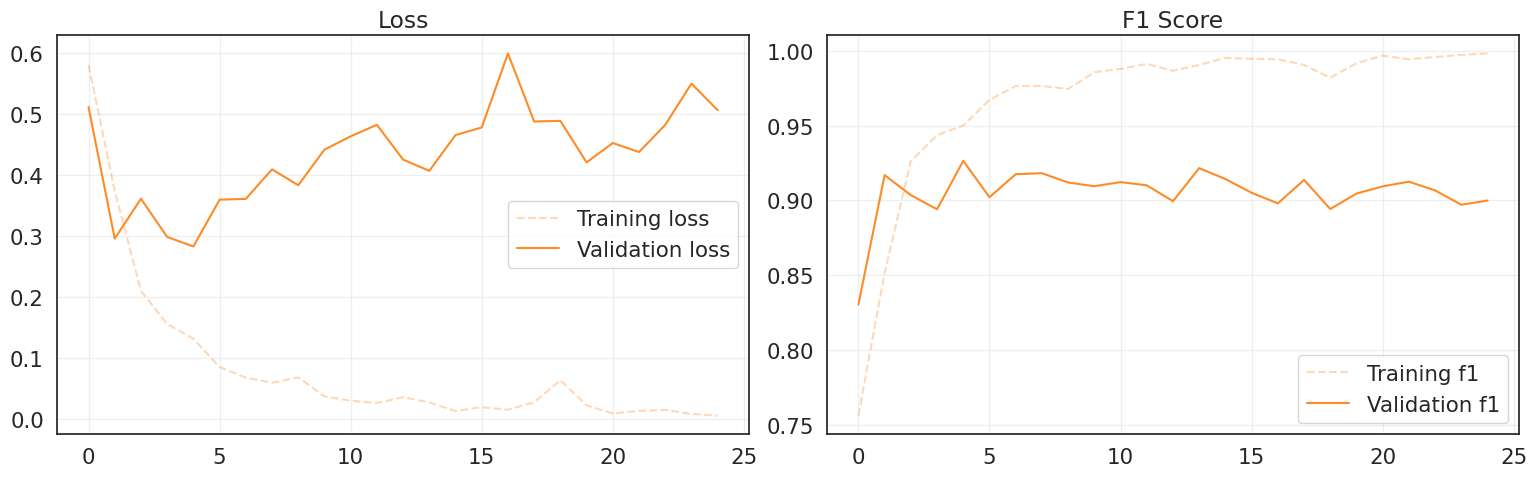

In [41]:
# @title Plot History
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9318
Precision over the validation set: 0.9243
Recall over the validation set: 0.9318
F1 score over the validation set: 0.9265
ROC AUC score over the validation set: 0.8908


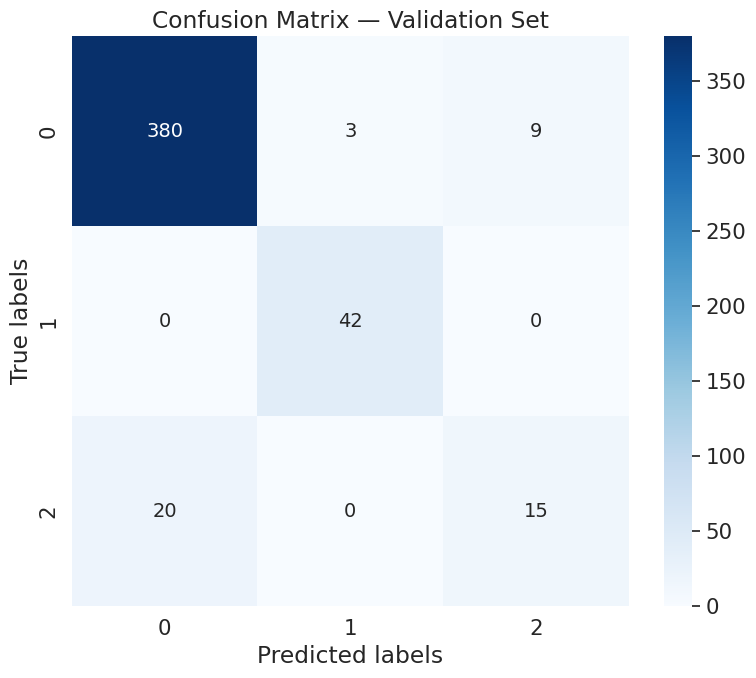

In [42]:
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

# Collect predictions, ground truth labels, and probabilities
val_preds, val_targets, val_probs = [], [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions (logits)
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())
        val_probs.append(probs)

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)
val_probs = np.concatenate(val_probs)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
val_roc_auc = roc_auc_score(val_targets, val_probs, multi_class='ovr', average='weighted')

print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")
print(f"ROC AUC score over the validation set: {val_roc_auc:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [43]:
# Create a function to perform predictions and loop through the test_loader

def predict(model, data_loader, device):
    """
    Perform inference on a dataset using a trained model.

    Args:
        model (nn.Module): The trained neural network model.
        data_loader (DataLoader): PyTorch DataLoader containing the inference data.
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU).

    Returns:
        list: A list of predicted class indices for each sample (window).
    """
    model.eval()  # Set model to evaluation mode
    predictions = []
    sample_indices = [] # To store sample_index for each window

    with torch.no_grad():  # Disable gradient computation for inference
        for batch in data_loader:
            # DataLoaders for test_ds have only features, not labels
            if isinstance(batch, list):
                xb = batch[0].to(device)
            else:
                xb = batch.to(device)

            # Original sample indices corresponding to this batch of windows
            # We need to trace back to the original sample_index for each window
            # This requires accessing the original test_df_processed data structure.
            # Let's assume the test_ds is ordered by original sample_index and then time.
            # We can calculate the original sample index based on batch index and window/stride

            # This approach is complex. A simpler way is to add sample_index to the test_ds.
            # Let's modify the data preparation step to include sample_index with each window.

            # For now, let's make predictions without associating them back to sample_index yet
            # We will need to revise the data loading or prediction process to handle sample_index.
            # Let's make predictions for the windows first.

            # Forward pass: get model predictions (logits)
            logits = model(xb)
            preds = logits.argmax(dim=1).cpu().numpy()
            predictions.extend(preds)

    return predictions

# Make predictions on the test data
test_predictions_windows = predict(rnn_model, test_loader, device)

print(f"Number of predictions for test windows: {len(test_predictions_windows)}")

Number of predictions for test windows: 9268


In [44]:
from collections import Counter
import numpy as np

# Aggregate predictions per user using a majority vote

# We need to map each window prediction back to its original sample_index.
# The build_sequences function groups by sample_index, so the windows in X_test
# are ordered by sample_index, then time within each sample_index.
# We know each user has 160 time stamps and the window size is 30 with stride 30.
# Number of windows per user = (total_time_stamps - window_size) // stride + 1
windows_per_user = (160 - WINDOW_SIZE) // STRIDE + 1
print(f"Number of windows per user: {windows_per_user}")

# Get the unique sample_indices from the original test data to maintain order
unique_test_sample_indices = X_test_seq['sample_index'].unique()

# Aggregate predictions for each user
user_predictions = {}
current_window_index = 0

for sample_index in unique_test_sample_indices:
    # Get the predictions corresponding to the windows of the current user
    user_window_predictions = test_predictions_windows[current_window_index : current_window_index + windows_per_user]

    # Perform majority vote
    prediction_counts = Counter(user_window_predictions)
    # Handle tie-breaking if necessary, for simplicity, Counter.most_common picks one arbitrarily
    final_user_prediction = prediction_counts.most_common(1)[0][0]

    user_predictions[sample_index] = final_user_prediction

    # Move to the next user's windows
    current_window_index += windows_per_user

print(f"Number of user predictions: {len(user_predictions)}")
# print("Example user predictions:", dict(list(user_predictions.items())[:10])) # Print first 10 for preview

Number of windows per user: 7
Number of user predictions: 1324


In [45]:
# Map Numerical Predictions to Labels
# Invert the label mapping
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Map numerical predictions back to labels
user_predictions_labels = {sample_index: inverse_label_mapping[pred_numeric]
                             for sample_index, pred_numeric in user_predictions.items()}

# print("Example user predictions (labels):", dict(list(user_predictions_labels.items())[:10])) # Print first 10 for preview

In [46]:
# Create Submission DataFrame
# Create a DataFrame from the user predictions
submission_df = pd.DataFrame.from_dict(user_predictions_labels, orient='index', columns=['label'])
submission_df.index.name = 'sample_index' # Rename index to sample_index

# Ensure the sample_index is a column, not the index
submission_df.reset_index(inplace=True)


print("Submission DataFrame shape:", submission_df.shape)
display(submission_df.head())

# Verify the number of users matches the sample submission
print(f"\nNumber of users in submission: {submission_df.shape[0]}")

Submission DataFrame shape: (1324, 2)


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,no_pain
3,3,no_pain
4,4,no_pain



Number of users in submission: 1324


In [47]:
# Save Submission File
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"\nSubmission file '{submission_filename}' created successfully.")


Submission file 'submission.csv' created successfully.
